In [21]:
# Helpers for multi-sweep comparisons
import pandas as pd
import numpy as np
import wandb

def fetch_sweep_df(sweep_path: str, timeout: int = 60) -> pd.DataFrame:
    """Fetch runs for a W&B sweep path 'entity/project/sweep_id' into a tidy DataFrame.
    Returns DataFrame with columns: run_id, name, state, final/best_r2, model/num_parameters, plus a few config fields.
    """
    api = wandb.Api(timeout=timeout)
    try:
        sweep = api.sweep(path=sweep_path)
    except Exception as e:
        print(f"Failed to load sweep {sweep_path}: {e}")
        return pd.DataFrame()

    recs = []
    for r in sweep.runs:
        s = dict(r.summary or {})
        c = dict(r.config or {})
        num_params = s.get("model/num_params") or s.get("model/num_parameters")
        recs.append({
            "run_id": r.id,
            "name": r.name,
            "state": r.state,
            "final/best_r2": s.get("final/best_r2"),
            "model/num_parameters": num_params,
            "model.ssm_dim": c.get("model.ssm_dim"),
            "model.ssm_io_dim": c.get("model.ssm_io_dim"),
            "model.ssm_num_layers": c.get("model.ssm_num_layers"),
            "optimizer.lr": c.get("optimizer.lr"),
            "optimizer.weight_decay": c.get("optimizer.weight_decay"),
            "model.dropout_p": c.get("model.dropout_p"),
            "dataset_args.recording_id": c.get("dataset_args.recording_id"),
        })
    df = pd.DataFrame.from_records(recs)
    if df.empty:
        return df
    df = df.dropna(subset=["final/best_r2", "model/num_parameters"]).copy()
    df = df[df["model/num_parameters"] > 0]
    return df


def compute_best_per_size(df: pd.DataFrame) -> pd.DataFrame:
    """Return the best-performing (max r2) run for each unique parameter count."""
    if df.empty:
        return df
    best = (
        df.sort_values(["model/num_parameters", "final/best_r2"], ascending=[True, False])
          .groupby("model/num_parameters", as_index=False)
          .first()
    )
    return best


def compute_pareto(best_per_size: pd.DataFrame) -> pd.DataFrame:
    """Pareto front where we minimize parameters and maximize r2.
    Expects best_per_size with columns model/num_parameters and final/best_r2.
    """
    if best_per_size.empty:
        return best_per_size
    pts = best_per_size[["model/num_parameters", "final/best_r2"]]
    pts = pts.sort_values(["model/num_parameters", "final/best_r2"], ascending=[True, False]).reset_index(drop=True)
    mask = np.zeros(len(pts), dtype=bool)
    current = -np.inf
    for i, row in pts.iterrows():
        r2 = row["final/best_r2"]
        if r2 > current:
            mask[i] = True
            current = r2
    return pts[mask].copy()


# Helpers to load minimal plot data and reconstruct DataFrames
import json
from pathlib import Path
from typing import Optional, List, Tuple

import pandas as pd


def load_plot_payload(json_path: Path) -> Optional[dict]:
    """Load saved minimal plot data safely. Returns dict or None if not readable."""
    try:
        if not json_path.exists():
            return None
        if json_path.stat().st_size < 2:  # too small to be valid JSON
            return None
        with open(json_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        # Basic schema check
        if not isinstance(payload, dict) or "datasets" not in payload:
            return None
        if not isinstance(payload["datasets"], list):
            return None
        return payload
    except Exception as e:
        print(f"Failed to load JSON from {json_path}: {e}")
        return None


def payload_to_results(payload: dict) -> List[Tuple[str, pd.DataFrame, pd.DataFrame]]:
    """Convert payload into list of (label, best_df, pareto_df) tuples."""
    out = []
    for ds in payload.get("datasets", []):
        label = ds.get("label", "unknown")
        b = ds.get("best_per_size", {})
        p = ds.get("pareto", {})
        best_df = pd.DataFrame({
            "model/num_parameters": b.get("params", []),
            "final/best_r2": b.get("r2", []),
        })
        pareto_df = pd.DataFrame({
            "model/num_parameters": p.get("params", []),
            "final/best_r2": p.get("r2", []),
        })
        out.append((label, best_df, pareto_df))
    return out

Monkey T, CO 20130909: runs=243 best_per_size=48 pareto=4
RTT: runs=288 best_per_size=48 pareto=6
RTT: runs=288 best_per_size=48 pareto=6


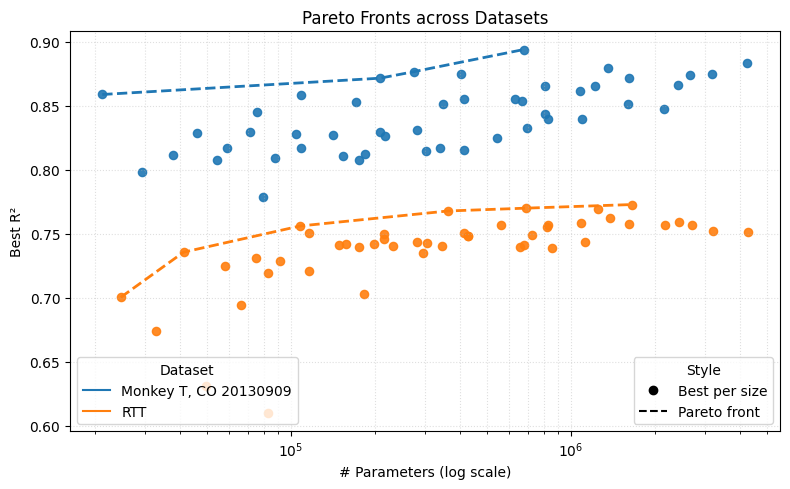

In [ ]:
# Compare multiple sweeps: best-per-size and Pareto front overlays
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import json, os

# List of sweeps to compare; add more entries as needed
# Format: (label, "entity/project/sweep_id")
sweeps = [
    ("Monkey T, CO 20130909", "melinajingting-ucl/foundational_ssm_pm_sweep/7liur42y"),
    ("RTT", "melinajingting-ucl/foundational_ssm_rtt_sweep/kwwvplrp"),
]

# Optional color mapping; unknown labels will default to gray
colors = {
    "Monkey T, CO 20130909": "tab:blue",
    "RTT": "tab:orange",
}

# Try loading precomputed minimal results; else fetch and save
json_path = Path("results/pareto_plot_data.json")
payload = load_plot_payload(json_path)
results = []

if payload is not None:
    # Use cached results
    results = payload_to_results(payload)
    # Ensure we have a color for any new labels
    for label, _, _ in results:
        colors.setdefault(label, 'gray')
    print(f"Loaded cached results from {json_path}")
else:
    # Fetch anew from W&B sweeps and compute best/per-size + Pareto
    fetched = []
    for label, path in sweeps:
        df_s = fetch_sweep_df(path)
        if df_s.empty:
            print(f"No data for {label} ({path})")
            continue
        best = compute_best_per_size(df_s)
        pareto = compute_pareto(best)
        fetched.append((label, best, pareto))
        colors.setdefault(label, 'gray')
        print(f"{label}: runs={len(df_s)} best_per_size={len(best)} pareto={len(pareto)}")
    results = fetched

    # Save minimal payload atomically for future runs
    try:
        plot_payload = {"datasets": []}
        for label, best, pareto in results:
            plot_payload["datasets"].append({
                "label": label,
                "best_per_size": {
                    "params": best["model/num_parameters"].tolist(),
                    "r2": best["final/best_r2"].tolist(),
                },
                "pareto": {
                    "params": pareto["model/num_parameters"].tolist(),
                    "r2": pareto["final/best_r2"].tolist(),
                },
            })
        json_path.parent.mkdir(parents=True, exist_ok=True)
        _tmp = json_path.with_suffix(json_path.suffix + ".tmp")
        with open(_tmp, "w", encoding="utf-8") as f:
            json.dump(plot_payload, f)
        os.replace(_tmp, json_path)
        print(f"Saved minimal plot data -> {json_path}")
    except Exception as e:
        print(f"Warning: failed to save minimal plot data: {e}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for label, best, pareto in results:
    c = colors.get(label, None)
    # Best-per-size points (dot)
    ax.scatter(best["model/num_parameters"], best["final/best_r2"], s=35, alpha=0.9, color=c)
    # Pareto line (dash)
    ax.plot(pareto["model/num_parameters"], pareto["final/best_r2"], lw=2, color=c, linestyle="--")

ax.set_xscale("log")
ax.set_xlabel("# Parameters (log scale)")
ax.set_ylabel("Best R²")
ax.set_title("Pareto Fronts across Datasets")
ax.grid(True, which="both", ls=":", alpha=0.4)

# Legends: style legend (dot vs dash) and color legend (dataset name)
style_handles = [
    Line2D([0], [0], marker='o', color='k', linestyle='None', markersize=6, label='Best per size'),
    Line2D([0], [0], color='k', linestyle='--', label='Pareto front'),
]
leg1 = ax.legend(handles=style_handles, title='Style', loc='lower right', frameon=True)
ax.add_artist(leg1)

color_handles = [
    Line2D([0], [0], color=colors.get(label, 'gray'), linestyle='-', label=label)
    for (label, _, _) in results
]
ax.legend(handles=color_handles, title='Dataset', loc='lower left', frameon=True)

plt.tight_layout()
plt.show()

In [19]:
# Save minimal plot data for quick future re-runs
import json
from pathlib import Path

plot_payload = {
    "datasets": []
}
for label, best, pareto in results:
    plot_payload["datasets"].append({
        "label": label,
        "best_per_size": {
            "params": best["model/num_parameters"].tolist(),
            "r2": best["final/best_r2"].tolist(),
        },
        "pareto": {
            "params": pareto["model/num_parameters"].tolist(),
            "r2": pareto["final/best_r2"].tolist(),
        },
    })

out_dir = Path("results")
out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / "pareto_plot_data.json"
with open(json_path, "w") as f:
    json.dump(plot_payload, f)
print(f"Saved minimal plot data -> {json_path}")

Saved minimal plot data -> results/pareto_plot_data.json


In [ ]:
# Helpers to load minimal plot data and reconstruct DataFrames
import json
from pathlib import Path
from typing import Optional, List, Tuple

import pandas as pd


def load_plot_payload(json_path: Path) -> Optional[dict]:
    """Load saved minimal plot data safely. Returns dict or None if not readable."""
    try:
        if not json_path.exists():
            return None
        if json_path.stat().st_size < 2:  # too small to be valid JSON
            return None
        with open(json_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        # Basic schema check
        if not isinstance(payload, dict) or "datasets" not in payload:
            return None
        if not isinstance(payload["datasets"], list):
            return None
        return payload
    except Exception as e:
        print(f"Failed to load JSON from {json_path}: {e}")
        return None


def payload_to_results(payload: dict) -> List[Tuple[str, pd.DataFrame, pd.DataFrame]]:
    """Convert payload into list of (label, best_df, pareto_df) tuples."""
    out = []
    for ds in payload.get("datasets", []):
        label = ds.get("label", "unknown")
        b = ds.get("best_per_size", {})
        p = ds.get("pareto", {})
        best_df = pd.DataFrame({
            "model/num_parameters": b.get("params", []),
            "final/best_r2": b.get("r2", []),
        })
        pareto_df = pd.DataFrame({
            "model/num_parameters": p.get("params", []),
            "final/best_r2": p.get("r2", []),
        })
        out.append((label, best_df, pareto_df))
    return out